<a href="https://colab.research.google.com/github/immelstorun/Angles-detection-with-YOLO/blob/main/M87_angles_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет!
Команда M87 представляет свое решение задачи по расхождению угла строп.
Мы обучили нейросеть YOLOv8s pose на своем датасете (гпнефть), который подготовили из видеоряда. Разметку keypoints делали в сервисе робофлоу, отттуда же экспортировали датасет для Yolo.

https://github.com/immelstorun/Angles-detection-with-YOLO

In [1]:
import numpy as np
import math
import os
import random

import cv2
import numpy as np
from matplotlib import pyplot as pltm

from IPython.display import display, Image
from PIL import Image
#!nvidia-smi

from scipy import optimize

from PIL import ImageFont
from PIL import ImageDraw
from PIL.Image import core as _imaging
# import PyQt5
from PIL import ImageGrab

#!pip install ultralytics==8.0.196 -q
import ultralytics
from ultralytics import YOLO
print(ultralytics.checks())

Ultralytics YOLOv8.2.2  Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
Setup complete  (8 CPUs, 20.0 GB RAM, 111.1/119.2 GB disk)
None


In [45]:
!nvidia-smi

Sat Apr 27 13:23:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 970M      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P8              8W / 1000W |     376MiB /   3072MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Top vertex angle of the triangle: 42.75 degrees


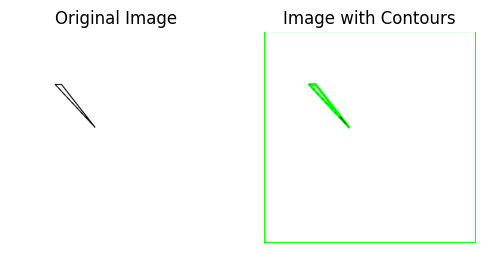

In [2]:
# Весь хакатон начинался с этого прототипа:)

def angle_between_points(p0, p1, p2):
    a = np.array(p0) - np.array(p1)
    b = np.array(p2) - np.array(p1)
    cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Set a random seed for reproducibility
#np.random.seed(5)

# Create a white image
width, height = 640, 640
image = np.ones((height, width, 3), dtype=np.uint8) * 255

# Generate coordinates for a random triangle
vertices = np.random.randint(100, 300, size=(3, 2))

# Draw the triangle
cv2.polylines(image, [vertices], isClosed=True, color=(0, 0, 0), thickness=2)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, threshold_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

# Find the triangle among contours and calculate the top angle
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) == 3:
        vertices = approx.reshape(-1, 2)
        vertices = vertices[np.argsort(vertices[:, 1])]

        top_angle = angle_between_points(vertices[1], vertices[0], vertices[2])
        print(f"Top vertex angle of the triangle: {top_angle:.2f} degrees")
        break
else:
    print("Triangle not found")

# Convert BGR images to RGB for displaying in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

# Display the images side by side using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

# Display the original image
axs[0].imshow(image_rgb)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the image with contours
axs[1].imshow(contour_image_rgb)
axs[1].set_title('Image with Contours')
axs[1].axis('off')

plt.show()

## Подготовка датасета - Roboflow keypoints annotation

![Screenshot from 2024-04-25 10-58-19.png](<attachment:Screenshot from 2024-04-25 10-58-19.png>)
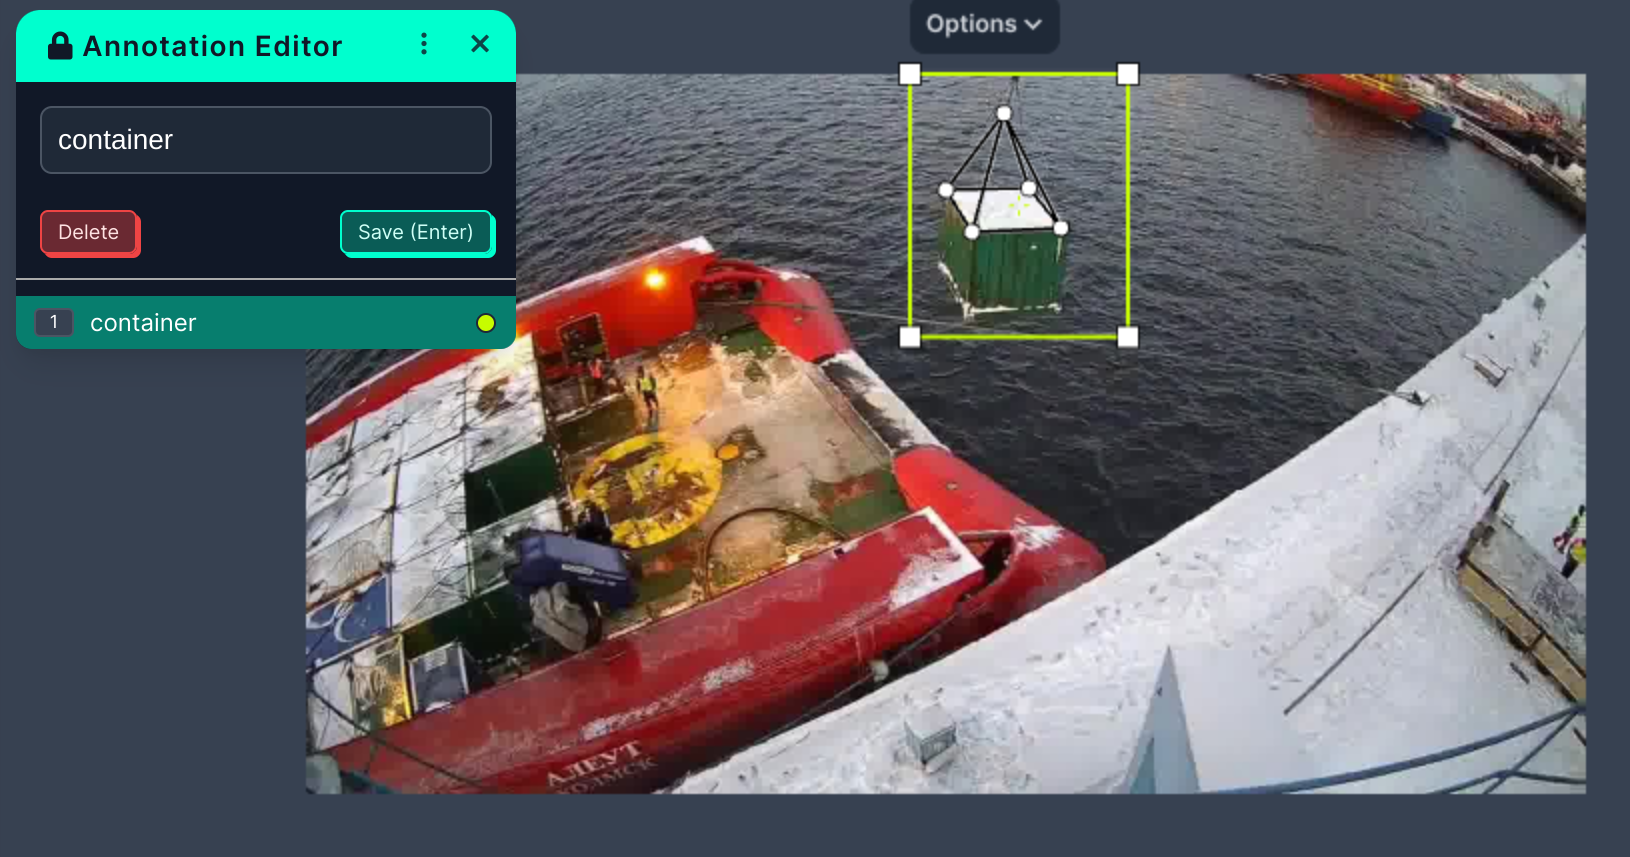

## Train a YOLOv8 Keypoint Detection Model


In [13]:
model = YOLO('yolov8m-pose.pt') # yolo pretrained model size
results = model.train(data=f"data/labeled/v5/data.yaml", epochs=300, imgsz=640)

100%|██████████| 50.8M/50.8M [00:17<00:00, 2.98MB/s]


New https://pypi.org/project/ultralytics/8.2.3 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2  Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
engine\trainer: task=pose, mode=train, model=yolov8m-pose.pt, data=data/labeled/v5/data.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning G:\github\Angles-detection-with-YOLO\data\labeled\v5\train\labels... 128 images, 0 backgrounds, 51 corrupt: 100%|██████████| 128/128 [00:00<00:00, 905.52it/s]

train: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\train\images\100_jpg.rf.6ac401841dfdaf20fca875dc822600f7.jpg: ignoring corrupt image/label: negative label values [  -0.016315]
train: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\train\images\101_jpg.rf.2e384403147f2879b468c90aa10f6271.jpg: ignoring corrupt image/label: negative label values [   -0.02474]
train: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\train\images\102_jpg.rf.806786581578c84cadf5860487fb0b65.jpg: ignoring corrupt image/label: negative label values [  -0.014493]
train: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\train\images\104_jpg.rf.08dee130be2945b6ec937da426bab903.jpg: ignoring corrupt image/label: negative label values [ -0.0020978]
train: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\train\images\105_jpg.rf.803c24a2c34b68354551a379e87f4b63.jpg: ignoring corrupt image/label: negative label values [  -0.014451]
train: WARNING 


val: Scanning G:\github\Angles-detection-with-YOLO\data\labeled\v5\valid\labels... 36 images, 0 backgrounds, 12 corrupt: 100%|██████████| 36/36 [00:00<00:00, 719.95it/s]

val: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\valid\images\103_jpg.rf.51fa107a983a113b98403105a17db033.jpg: ignoring corrupt image/label: negative label values [  -0.013355]
val: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\valid\images\107_jpg.rf.94b9faab30ac74aa162977a48560edf1.jpg: ignoring corrupt image/label: negative label values [ -0.0088631]
val: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\valid\images\160_jpg.rf.5cf6ac1d18ac02b811e5124b65fe4802.jpg: ignoring corrupt image/label: negative label values [  -0.022131]
val: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\valid\images\53_jpg.rf.4ebb73dcc7cad6a5511d88b7e64f9c4c.jpg: ignoring corrupt image/label: negative label values [ -0.0095869]
val: WARNING  G:\github\Angles-detection-with-YOLO\data\labeled\v5\valid\images\69_jpg.rf.b230ef2bc942e55751e309956830f2cb.jpg: ignoring corrupt image/label: negative label values [    -0.0625]
val: WARNING  G:\github\Ang

Plotting labels to runs\pose\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 83 weight(decay=0.0), 93 weight(decay=0.0005), 92 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\pose\train2
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      6.64G      2.663      4.321     0.7096      5.797       2.93         21        640: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         24         24          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300       6.6G      2.396      4.416     0.7138      4.583      2.637         27        640: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24      0.451      0.625      0.604      0.226       0.51        0.5      0.448     0.0717



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300       6.8G      1.777       3.24     0.6891      2.183      2.026         19        640: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.118      0.125     0.0465     0.0162      0.118      0.125     0.0471    0.00845



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      6.83G      1.632      2.632     0.7051       1.66      1.976         20        640: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         24         24      0.106      0.125     0.0585     0.0282      0.106      0.125     0.0635     0.0161



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300      6.84G      1.621      2.431     0.7033       1.32      2.014         25        640: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         24         24      0.693      0.875      0.753      0.363      0.726      0.917      0.809      0.315



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      6.82G       1.85       2.26      0.635       1.58      2.273         13        640: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         24         24      0.579      0.708      0.566      0.244      0.579      0.708      0.607      0.268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300      6.84G      1.595      2.022     0.6392      1.298      1.982         28        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         24         24      0.713      0.622      0.741      0.196      0.765      0.708       0.82      0.312



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      6.82G      1.875       2.28     0.6213      1.257      2.165         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         24         24     0.0417       0.75     0.0429     0.0208     0.0417       0.75     0.0429     0.0195



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      6.84G      1.952      1.963     0.6203      1.513       2.19         22        640: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         24         24     0.0101      0.583    0.00939    0.00356    0.00952       0.54    0.00745    0.00348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      6.82G      1.606      1.875     0.6013      1.263      1.987         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         24         24    0.00806      0.417     0.0126    0.00217    0.00842      0.333     0.0073    0.00125



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      6.85G      1.539      2.086     0.5429        1.3      1.907         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24    0.00806      0.417     0.0126    0.00217    0.00842      0.333     0.0073    0.00125



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      6.82G      1.519      2.018     0.5094      1.236      1.942         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24    0.00806      0.417     0.0126    0.00217    0.00842      0.333     0.0073    0.00125



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      6.82G      1.793      1.852      0.512       1.32      2.068         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         24    0.00806      0.417     0.0126    0.00217    0.00842      0.333     0.0073    0.00125



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      6.86G      1.698      1.925     0.4816      1.278      2.063         37        640: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         24         24     0.0015     0.0417   0.000731   7.31e-05          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      6.85G       1.75      1.905     0.4516      1.277      2.116         23        640: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         24         24    0.00198     0.0417     0.0016    0.00016          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      6.83G      1.719      1.748     0.4642      1.256      2.071         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         24         24    0.00198     0.0417     0.0016    0.00016          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      6.85G      1.708        1.7     0.4518      1.405      2.059         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24         24    0.00198     0.0417     0.0016    0.00016          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      6.86G      1.686        2.1     0.4494      1.282      2.026         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         24         24    0.00198     0.0417     0.0016    0.00016          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      6.86G      1.721      1.753     0.4572      1.341      2.158         18        640: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         24         24    0.00855     0.0417    0.00509   0.000509      0.025     0.0833     0.0117    0.00168



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      6.87G      1.773      1.725     0.4286      1.274      2.178         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         24         24    0.00855     0.0417    0.00509   0.000509      0.025     0.0833     0.0117    0.00168



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      6.82G      1.724      1.749     0.4341      1.154      2.114         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24    0.00538      0.583     0.0133    0.00198          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      6.82G      1.772      1.998     0.4219      1.199       2.15         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         24         24    0.00471       0.75    0.00532    0.00188   0.000416     0.0833   0.000198   5.83e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      6.86G      1.791      1.706     0.4063      1.219      2.195         17        640: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         24         24     0.0246      0.167    0.00877    0.00176     0.0131     0.0833     0.0047     0.0011



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      6.87G      1.881      1.845     0.4084      1.228      2.195         27        640: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         24         24    0.00174      0.167    0.00121    0.00023    0.00106     0.0417   0.000572    0.00017



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      6.81G       1.77      1.793       0.39      1.423      2.171         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24    0.00412      0.458    0.00395     0.0012     0.0214     0.0417    0.00633    0.00134



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      6.83G      1.495      1.904     0.3628      1.094      1.862         33        640: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         24         24     0.0289      0.352     0.0235    0.00925      0.034      0.415     0.0224    0.00944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      6.85G      1.568      1.634     0.3949      1.176      1.949         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24     0.0619      0.792     0.0579     0.0199      0.074      0.417     0.0673     0.0293



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      6.87G       1.71      2.074     0.4165      1.251      2.105         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         24         24      0.117      0.542        0.2     0.0566      0.143      0.667      0.223        0.1



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      6.83G      1.626      1.688     0.3876      1.274      2.002         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         24         24      0.502      0.708      0.696      0.241      0.552      0.792      0.744      0.246



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      6.82G      1.786      1.785     0.4463      1.208      2.161         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         24         24      0.637       0.75      0.739      0.289      0.697      0.766       0.77       0.49



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      6.86G      1.569      1.506     0.3749      1.121       1.98         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         24         24      0.152      0.583      0.151     0.0652       0.39      0.692       0.48      0.197



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      6.86G      1.584      1.783     0.3352      1.179      1.971         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24      0.145      0.625      0.135      0.062      0.208      0.458      0.195      0.117



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      6.82G       1.67      1.633     0.3886      1.179       2.11         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         24         24      0.109       0.75      0.103     0.0424      0.147      0.625      0.152     0.0823



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300      6.85G      1.677       1.34     0.3494      1.167      2.036         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         24      0.351      0.518      0.329      0.109      0.489      0.667      0.494      0.236



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300      6.86G      1.585      1.735     0.3633      1.189      1.931         17        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         24         24      0.111      0.333     0.0886     0.0305      0.177      0.625      0.201     0.0663



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300      6.86G      1.588      1.339      0.388      1.305      2.062         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         24       0.51      0.478       0.49      0.177      0.495      0.417      0.448      0.368



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300       6.8G      1.529       1.37     0.3495       1.18      1.923         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24      0.554      0.667      0.673      0.238      0.485      0.583      0.596      0.456



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300      6.84G      1.449      1.404     0.3548      1.155      1.897         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         24         24      0.621      0.616      0.508       0.19      0.707      0.705      0.662      0.405



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300      6.86G      1.615      1.666     0.3574      1.207      2.059         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         24         24      0.135      0.417      0.145      0.049      0.175      0.542      0.214        0.1



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300      6.85G      1.588      1.567     0.2985      1.152      2.009         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         24         24      0.712      0.667      0.729      0.268      0.667      0.625      0.766      0.543



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300      6.83G      1.709      1.553     0.3796       1.27       2.05         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         24       0.45        0.5      0.465      0.213      0.448        0.5      0.489       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300      6.83G       1.58      1.469     0.3172      1.204      1.905         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24         24      0.745      0.583      0.589      0.302      0.687      0.542      0.616      0.447



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300      6.85G      1.573      1.237     0.3298      1.214       1.94         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         24         24      0.611      0.667      0.652      0.238      0.613      0.667      0.678      0.385



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300      6.85G      1.483      1.355     0.3587      1.175       1.87         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         24         24      0.755       0.75      0.705      0.301      0.727      0.776      0.667      0.307



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300      6.83G      1.674      1.358     0.3379      1.114      2.077         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24      0.567       0.82      0.778      0.313      0.567       0.82      0.778      0.317



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300      6.85G      1.518      1.302     0.3057      1.094      1.897         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.902      0.875      0.947      0.465      0.834      0.835      0.866      0.499



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300      6.87G       1.52      1.174     0.2843      1.096      1.926         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24         24      0.843      0.875      0.927      0.452      0.818      0.833      0.906      0.561



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      6.86G      1.455      1.139     0.3249      1.036      1.902         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24         24      0.537      0.792       0.73      0.369      0.584      0.761      0.759      0.449



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      6.82G      1.483       1.28     0.2859      1.088       1.94         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.422      0.792      0.533      0.263      0.448      0.792      0.519      0.361



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      6.84G       1.46      1.281     0.2753      1.107        1.9         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         24         24      0.661      0.732      0.692      0.328      0.684      0.708      0.741      0.501



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      6.84G       1.57      1.273     0.3351       1.17       1.93         28        640: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         24         24      0.544        0.5      0.507      0.208      0.544        0.5       0.52      0.397



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      6.86G       1.61      1.355     0.3194      1.156      1.944         23        640: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         24         24      0.732      0.708      0.728      0.329      0.732      0.708      0.728      0.546



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      6.83G      1.483      1.195      0.302      1.007       1.88         29        640: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         24         24      0.766      0.833      0.843      0.431      0.716      0.792      0.777      0.589



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      6.82G       1.57      1.404     0.3253      1.142      1.945         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.553      0.958      0.776      0.461      0.553      0.876      0.697      0.555



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      6.85G      1.491      1.039     0.2687      1.181      1.911         20        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         24         24      0.684      0.833      0.761      0.468      0.619       0.75      0.687      0.563



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      6.84G      1.404      1.442     0.2837      1.161      1.864         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         24         24      0.754      0.917      0.939      0.435      0.647      0.792      0.744      0.638



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      6.82G      1.426      1.298     0.2529      1.046      1.843         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         24      0.968      0.958      0.984      0.459      0.753      0.833      0.786      0.701



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      6.84G      1.486      1.294     0.2966      1.108      1.918         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.824      0.782      0.898      0.438      0.763      0.804       0.77       0.64



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      6.84G      1.497      1.144     0.3213      1.047       1.86         17        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         24         24       0.98      0.958      0.982      0.487      0.937      0.917      0.946      0.684



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      6.85G      1.515      1.412     0.2964      1.104      1.929         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         24      0.921       0.97       0.99      0.497      0.882      0.937      0.966      0.614



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      6.83G      1.506      1.406       0.29       1.03       1.92         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         24         24      0.955          1      0.995       0.49      0.914      0.958      0.975      0.683



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      6.83G      1.433      1.207     0.2995      1.055       1.82         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24      0.916      0.958      0.973      0.476      0.876      0.917      0.931      0.626



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      6.86G      1.463      1.209     0.2742      1.067       1.99         20        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         24         24      0.818      0.917      0.912      0.442      0.818      0.917      0.928      0.591



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      6.85G      1.406      1.471      0.334       1.13      1.874         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24      0.945          1      0.995      0.566      0.902      0.958      0.947       0.79



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      6.83G      1.428      1.334      0.262      1.112      1.809         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         24         24      0.955      0.917      0.987      0.543      0.748      0.875      0.848      0.777



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      6.85G      1.381      1.045     0.3093      1.055      1.852         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.854      0.972      0.983      0.505      0.745      0.851      0.854      0.757



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      6.86G      1.349      1.336     0.2957      1.066      1.785         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.873      0.958       0.98      0.528      0.778      0.875      0.923      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      6.86G      1.357      1.259      0.299      1.099      1.841         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.918      0.833      0.977      0.497      0.918      0.833      0.977      0.714



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      6.83G      1.331      1.336     0.2951      1.084      1.805         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         24         24      0.954      0.867       0.98      0.506      0.832      0.875      0.925      0.751



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      6.84G      1.341      1.227     0.2217      1.033       1.79         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         24         24      0.928          1      0.992      0.546      0.807      0.875      0.842      0.764



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      6.86G      1.549      1.136      0.282      1.153      1.931         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         24         24      0.992          1      0.995      0.612      0.868      0.875       0.83      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      6.85G      1.475      1.141     0.3022       1.08       1.88         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         24         24      0.941      0.958      0.966       0.55      0.859      0.875      0.826      0.682



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      6.83G      1.434      1.049     0.2518      1.035      1.808         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         24         24      0.989          1      0.995      0.522      0.865      0.875      0.829      0.722



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      6.83G      1.421      1.374     0.2494      1.118      1.879         25        640: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24      0.985          1      0.995      0.562      0.862      0.875      0.833      0.745



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      6.87G      1.429      1.026     0.2554      1.082      1.863         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         24         24      0.963          1      0.995      0.588      0.842      0.875      0.847       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      6.87G      1.331      1.314     0.2275      1.065      1.776         32        640: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         24         24      0.973          1      0.995       0.47       0.85      0.875      0.854      0.719



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      6.83G      1.319      1.473     0.2905      1.025      1.747         22        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         24         24      0.972          1      0.995      0.465      0.891      0.917      0.924      0.742



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      6.83G      1.422      0.986     0.2993      1.042      1.888         21        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         24         24      0.987          1      0.995      0.482      0.904      0.917       0.91      0.676



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      6.84G       1.43       1.14     0.2654      1.002      1.885         24        640: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24      0.715      0.958      0.775      0.387      0.684      0.917      0.707      0.537



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      6.87G      1.517      1.126     0.2467      1.055      1.873         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.731        0.5      0.716      0.301      0.675      0.458      0.603      0.446



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      6.83G      1.443     0.9356     0.2569          1      1.853         23        640: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         24         24      0.929      0.417      0.692      0.335      0.608      0.458       0.61      0.459



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      6.86G      1.557     0.9732     0.2431      1.092       1.91         18        640: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         24         24      0.877      0.917      0.918      0.436      0.827      0.795      0.854      0.678



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      6.86G      1.473      1.025     0.2352      1.107      1.961         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         24         24      0.957      0.939       0.95      0.483      0.915      0.897      0.883      0.676



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      6.85G      1.432       1.28     0.2403      1.151      1.887         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         24         24      0.929      0.958      0.954      0.584      0.929      0.958       0.92      0.626



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      6.82G      1.341      1.128     0.2494      1.053      1.798         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24      0.979          1      0.995        0.6      0.938      0.958      0.936      0.795



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      6.84G      1.353      1.073      0.266      1.089      1.734         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24      0.988          1      0.995      0.595      0.947      0.958      0.926       0.82



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      6.87G      1.396      1.065     0.2341      1.065      1.796         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24       0.95          1      0.995      0.584      0.868      0.917      0.908      0.806



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      6.85G      1.295      1.091     0.2721      1.048      1.785         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         24         24      0.955       0.88      0.957       0.54      0.953      0.838      0.967      0.797



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      6.82G      1.366     0.8131     0.2315       1.08      1.729         24        640: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24      0.808      0.958      0.962      0.574      0.951      0.816      0.915      0.795



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      6.83G      1.445     0.9756     0.2675      1.057      1.839         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24      0.912          1      0.976      0.536      0.839      0.917      0.883      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      6.86G      1.363     0.8121     0.2085      1.064      1.814         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         24         24      0.967          1      0.995      0.465      0.925      0.958      0.955      0.772



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      6.84G      1.398     0.9065     0.2892      1.018       1.83         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         24         24      0.994          1      0.995       0.52      0.994          1      0.995      0.728



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      6.82G      1.397      1.011     0.2626       1.04      1.794         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24       0.99          1      0.995      0.528      0.906      0.917      0.869      0.679



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      6.82G      1.466      1.118     0.2405      1.072      1.952         19        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24      0.991          1      0.995      0.519      0.909      0.917      0.869      0.728



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      6.84G      1.369      1.001     0.2651     0.9628      1.833         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         24         24      0.949      0.958      0.958      0.542      0.865      0.875      0.826      0.748



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      6.87G      1.351     0.8865     0.2259      1.034      1.839         17        640: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         24         24      0.981          1      0.995      0.566       0.94      0.958      0.966       0.76



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      6.83G      1.433      1.094     0.2144      1.005      1.812         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         24         24      0.987          1      0.995      0.583      0.987          1      0.995      0.742



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      6.84G      1.403     0.8368     0.2154     0.9864      1.903         17        640: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         24         24      0.986          1      0.995      0.565      0.986          1      0.995      0.704



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      6.85G      1.343      1.262     0.2614      1.043      1.713         26        640: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         24         24      0.995          1      0.995      0.561      0.953      0.958      0.953      0.569



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      6.87G       1.43      1.199      0.247      1.082      1.853         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         24         24      0.921      0.965       0.98      0.534      0.958      0.954       0.95      0.483



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      6.81G      1.374      1.257     0.2605      1.076      1.783         36        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         24         24      0.938      0.958      0.952       0.58      0.979          1      0.995      0.665



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      6.82G       1.29     0.8878     0.2591      1.011      1.713         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         24      0.944      0.958      0.962      0.515      0.902      0.917      0.909      0.704



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      6.87G      1.371       1.16     0.2327      1.001      1.729         34        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         24         24      0.904      0.917      0.932      0.512      0.904      0.917      0.931      0.724



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      6.85G      1.445     0.7781     0.2024      1.043      1.944         14        640: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.944      0.958      0.975      0.607      0.944      0.958       0.94      0.799



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      6.82G      1.476     0.9118      0.225      1.038      1.896         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         24         24       0.96          1      0.995      0.627       0.92      0.958      0.942      0.763



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      6.83G      1.443     0.9569     0.2501      1.037      1.819         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         24         24      0.986          1      0.995      0.613      0.945      0.958      0.946      0.774



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      6.87G      1.294      0.934      0.236     0.9885      1.687         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.977          1      0.995       0.58      0.936      0.958      0.949      0.807



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      6.85G      1.478      1.098     0.2561      1.048      1.822         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24      0.992          1      0.995      0.551      0.951      0.958      0.933      0.755



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      6.83G      1.265     0.9617      0.238      1.002      1.696         27        640: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24      0.952      0.917      0.929      0.521      0.952      0.917      0.909      0.732



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      6.85G      1.255     0.8224     0.2072     0.9899       1.71         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         24         24      0.893      0.875      0.895      0.513      0.956      0.911      0.905      0.674



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      6.86G      1.332     0.9214      0.238     0.9612       1.81         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         24         24      0.858      0.833      0.848      0.486      0.858      0.833      0.814      0.616



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      6.85G       1.34      1.034     0.2486       1.02      1.745         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24      0.801      0.875       0.88      0.546      0.844      0.903      0.907      0.611



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      6.82G      1.375      1.044     0.2123      1.037      1.737         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.918      0.939       0.93      0.596      0.996          1      0.995      0.666



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      6.84G      1.326     0.8116     0.2569     0.9341      1.797         13        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24      0.958      0.955      0.986      0.621          1      0.996      0.995      0.701



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      6.83G      1.311     0.9386     0.2509      1.036      1.745         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24          1      0.991      0.995      0.586          1      0.991      0.995      0.689



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      6.86G      1.268     0.8653     0.2537      0.953      1.669         34        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         24         24      0.953          1      0.995      0.545      0.953          1      0.995      0.689



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/300      6.83G      1.322      1.096     0.2256       0.98      1.748         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         24         24      0.959      0.972       0.99      0.552      0.959      0.972       0.99      0.705



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/300      6.84G      1.326     0.7924     0.2785     0.9678      1.749         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.958      0.952      0.971       0.57          1      0.994      0.995      0.766



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/300      6.85G      1.323      1.039     0.2074     0.9346      1.726         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         24         24      0.922      0.988      0.974      0.565      0.945          1      0.993      0.762



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/300      6.86G      1.402      1.001     0.2154     0.9833      1.782         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         24         24      0.958          1      0.977      0.602      0.974          1      0.995      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/300      6.83G      1.297      0.918     0.2395      0.969      1.732         34        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24       0.96          1      0.969      0.606      0.977          1      0.995       0.75



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/300      6.85G      1.345     0.9866     0.2588      1.012      1.826         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         24         24      0.989          1      0.995      0.623      0.989          1      0.995      0.737



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/300      6.85G      1.244     0.9476     0.2809     0.9758      1.743         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.992          1      0.995      0.614      0.992          1      0.995      0.718



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/300      6.86G      1.332     0.7158     0.2291     0.9205      1.831         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.993          1      0.995      0.593      0.993          1      0.995      0.763



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/300      6.81G      1.285      1.028     0.2047     0.9958      1.741         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.993          1      0.995      0.573      0.951      0.958      0.929      0.724



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/300      6.82G      1.298     0.7239     0.2324      0.919      1.759         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24      0.984          1      0.995      0.572      0.941      0.958      0.929       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/300      6.85G      1.207     0.8838     0.2421     0.9059       1.71         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         24      0.948      0.958      0.949      0.582      0.948      0.958      0.918      0.762



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/300      6.86G      1.362     0.9186     0.2064     0.9308      1.733         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24       0.95      0.958      0.959      0.592      0.867      0.875      0.792      0.752



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/300      6.83G      1.241     0.9168      0.284     0.9271      1.702         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         24         24      0.951      0.958       0.97      0.613       0.91      0.917      0.886      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/300      6.85G      1.305     0.8836     0.2317     0.8912      1.724         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24      0.942      0.958      0.956      0.593      0.942      0.958      0.917      0.765



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/300      6.87G      1.179     0.7799     0.2559     0.9173      1.603         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         24         24      0.935      0.958      0.944      0.549      0.976          1      0.995      0.729



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/300      6.86G      1.307     0.8298     0.2003     0.9498      1.772         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         24         24      0.941      0.958      0.951      0.517      0.982          1      0.995      0.735



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/300      6.83G      1.308     0.9909     0.1766      0.972      1.762         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24      0.945      0.958      0.947      0.518      0.945      0.958      0.969      0.705



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/300      6.84G      1.355     0.8942     0.1838     0.9939      1.869         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.947      0.958      0.945       0.53      0.989          1      0.995      0.708



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/300      6.84G      1.291     0.8694     0.2263     0.9962      1.747         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.947      0.958      0.957      0.564      0.988          1      0.995      0.724



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/300      6.86G      1.235     0.9691     0.2036     0.9306      1.697         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         24         24      0.958      0.956      0.954      0.552          1      0.997      0.995      0.745



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/300      6.82G      1.295     0.9591     0.2376     0.9347      1.745         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24          1      0.988      0.995       0.55          1      0.988      0.995      0.704



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/300      6.85G       1.36      1.031     0.1929     0.9537       1.78         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.944      0.958      0.991      0.548      0.944      0.958      0.991      0.597



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/300      6.85G      1.299     0.9508     0.2788     0.9648      1.713         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24      0.933      0.958      0.992      0.578      0.933      0.958      0.992      0.486



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/300      6.87G      1.227     0.9806     0.1584     0.8846      1.728         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24          1      0.981      0.995      0.542      0.958       0.94       0.94      0.535



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/300      6.83G      1.343     0.8311     0.2159     0.9984      1.761         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         24         24          1       0.99      0.995       0.58      0.958       0.95      0.944      0.605



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/300      6.85G      1.391     0.9921     0.2333      1.026       1.81         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         24         24      0.924      0.958      0.992      0.608      0.882      0.917      0.935      0.647



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/300      6.83G      1.222      0.753     0.2412     0.9428       1.72         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         24       0.96      0.958      0.991      0.614       0.84      0.833      0.858      0.667



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/300      6.87G      1.259     0.8475     0.2315     0.9817      1.697         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         24      0.946          1      0.995      0.592      0.834      0.875      0.858      0.696



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/300      6.82G      1.137     0.9011     0.2015      0.876      1.693         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         24         24      0.942      0.958      0.942       0.55        0.9      0.917      0.897      0.567



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/300      6.84G      1.213     0.9024     0.2372      0.943      1.675         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24         24      0.946      0.958      0.948      0.556      0.905      0.917      0.893      0.569



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/300      6.86G      1.271     0.8151     0.2285      0.941      1.729         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         24      0.947      0.958      0.948      0.577      0.947      0.958       0.96      0.656



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/300      6.86G      1.348     0.8984     0.2203     0.8948      1.786         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         24         24      0.953      0.958      0.944      0.586      0.995          1      0.995      0.682



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/300      6.83G      1.194     0.7302     0.2216     0.8405      1.683         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24      0.953      0.958      0.944      0.578      0.995          1      0.995      0.696



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/300      6.85G      1.241     0.6904     0.1924      0.881       1.72         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         24         24       0.92      0.953      0.922      0.574      0.953      0.958      0.965       0.76



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/300      6.84G      1.256     0.9451     0.2345     0.9281      1.772         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24      0.875      0.958      0.917      0.571      0.906      0.917      0.953      0.808



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/300      6.86G       1.31     0.8165     0.1504      0.879      1.744         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24         24       0.96      0.998      0.963      0.624      0.899      0.917      0.933      0.814



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/300      6.82G      1.257     0.8197     0.2024     0.8803      1.728         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         24         24      0.945      0.958       0.95      0.601      0.909      0.917      0.938      0.781



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/300      6.84G      1.259     0.7179     0.2066     0.9581      1.711         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         24         24      0.892      0.917      0.918      0.617      0.933      0.958       0.96      0.705



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/300      6.85G      1.244      1.007     0.1883     0.8553      1.706         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.949      0.958      0.948      0.597      0.907      0.917      0.864      0.674



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/300      6.88G      1.221     0.8609     0.2079     0.8511      1.666         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24         24      0.954      0.958      0.962      0.541      0.871      0.875       0.84      0.717



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/300      6.81G       1.27     0.7335     0.2744     0.9247      1.797         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24       0.96      0.995      0.965      0.605      0.871      0.875      0.837      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/300      6.84G      1.246     0.9465     0.2203     0.9322       1.71         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         24         24       0.96      0.996      0.965       0.61      0.871      0.875      0.846      0.797



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/300      6.84G      1.254      0.447     0.1815     0.8988      1.726         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24      0.952      0.958      0.963      0.595      0.869      0.875      0.858      0.801



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/300      6.87G      1.289     0.8331     0.1996     0.9307      1.727         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.942      0.958      0.959      0.647      0.942      0.958      0.953      0.787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/300      6.83G      1.268      0.805     0.2235     0.9271      1.774         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         24      0.923      0.997      0.961      0.636      0.906      0.958      0.949       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/300      6.85G      1.227     0.8312     0.2683     0.9187      1.676         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         24      0.987          1      0.995      0.626      0.987          1      0.995      0.722



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/300      6.86G      1.276     0.8267     0.2321     0.8597      1.742         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         24         24      0.985          1      0.995      0.613      0.985          1      0.995      0.738



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    164/300      6.85G      1.278     0.9322      0.221     0.9558      1.756         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         24         24      0.989          1      0.995      0.595      0.948      0.958      0.953      0.725



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    165/300      6.83G      1.243     0.7594     0.2323     0.9143      1.708         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         24         24      0.947      0.958       0.97      0.594      0.906      0.917      0.909      0.717



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    166/300      6.83G      1.243     0.7587     0.2039     0.8847       1.79         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         24         24      0.946      0.958       0.97      0.572      0.904      0.917      0.905      0.722



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    167/300      6.87G      1.127     0.6112     0.1979     0.8694       1.65         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.949      0.958      0.978      0.572      0.866      0.875      0.828      0.724



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    168/300      6.87G      1.205      0.783     0.1973     0.8822      1.687         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.908      0.917      0.949      0.615      0.949      0.958      0.932      0.674



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    169/300      6.82G      1.263     0.9098     0.1864     0.8803      1.649         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         24         24       0.95      0.958      0.973      0.616       0.95      0.958       0.93      0.649



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    170/300      6.85G      1.177     0.7156     0.1892     0.8196      1.623         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24         24      0.947      0.958      0.966       0.63      0.906      0.917      0.893      0.676



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    171/300      6.83G      1.219     0.6481     0.1879     0.9262      1.749         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         24         24       0.96      0.988      0.965      0.632      0.867      0.875      0.844      0.722



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    172/300      6.85G      1.213     0.7397     0.1965     0.8902       1.65         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.939      0.958      0.975      0.686      0.858      0.875      0.838      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    173/300      6.83G      1.113     0.7243     0.2726     0.8849      1.577         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         24         24      0.915      0.958      0.975      0.691      0.837      0.875      0.842      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    174/300      6.84G      1.261     0.7449     0.1942     0.9255      1.706         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24      0.919      0.958      0.974      0.666      0.844      0.875      0.831      0.788



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    175/300      6.84G      1.173     0.9246     0.1813     0.8829      1.663         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24       0.94      0.958      0.969      0.608      0.861      0.875      0.821      0.781



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    176/300      6.85G      1.157     0.6621     0.1925     0.8722      1.672         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24      0.943      0.958      0.972       0.53      0.861      0.875      0.854      0.791



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    177/300      6.83G      1.194     0.9309     0.2015     0.8901      1.662         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         24         24      0.927      0.958      0.975      0.586      0.844      0.875      0.878      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    178/300      6.85G       1.24     0.8447      0.212     0.9437      1.722         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         24      0.909      0.958      0.959      0.616       0.83      0.875      0.854      0.711



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    179/300      6.85G      1.287      0.868     0.1731     0.8904      1.676         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24         24      0.922      0.986      0.955      0.631      0.865      0.917      0.888      0.678



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    180/300      6.85G      1.244      1.008      0.247     0.9535      1.664         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24         24       0.96      0.989      0.972      0.597        0.9      0.917      0.922      0.608



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    181/300      6.83G      1.289     0.7431     0.2138     0.9315      1.749         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24      0.959      0.984      0.965      0.578      0.906      0.917      0.927      0.591



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    182/300      6.84G      1.187     0.7045      0.156     0.9027      1.742         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24       0.96      0.992      0.959       0.55      0.907      0.917      0.926      0.564



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    183/300      6.83G       1.14     0.5891      0.185     0.8569      1.617         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         24         24       0.96      0.993      0.959      0.535      0.909      0.917      0.922      0.592



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    184/300      6.86G       1.16     0.7417     0.1978     0.8711      1.687         20        640: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         24      0.954      0.958      0.965      0.521      0.963      0.958      0.975      0.691



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    185/300       6.8G      1.213     0.8782     0.2129     0.8833      1.728         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         24         24       0.96      0.995      0.975      0.589      0.996          1      0.995      0.707



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    186/300      6.83G       1.24     0.8594     0.2135      0.892      1.702         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         24       0.96      0.995      0.987      0.624      0.953      0.958      0.935      0.745



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    187/300      6.85G      1.203     0.7019     0.2031     0.7995      1.666         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24       0.96      0.995      0.989       0.64      0.911      0.917      0.925      0.764



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    188/300      6.84G      1.193     0.6608      0.189     0.8067      1.643         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         24         24       0.96      0.993      0.987      0.642      0.909      0.917      0.885      0.755



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    189/300      6.83G      1.238     0.8776      0.223     0.8403      1.663         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.991          1      0.995      0.646      0.908      0.917      0.887      0.766



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    190/300      6.83G      1.249      0.938     0.1759     0.8618      1.728         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.994          1      0.995      0.643      0.911      0.917       0.89      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    191/300      6.83G      1.159     0.7142     0.1775     0.8115      1.662         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         24      0.951      0.958      0.979      0.634      0.951      0.958      0.944      0.785



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    192/300      6.85G      1.147     0.5434     0.1958     0.8172      1.616         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24      0.936      0.958      0.982      0.602      0.902      0.917      0.911      0.813



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    193/300      6.84G      1.193     0.5641     0.1806     0.8433      1.667         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24         24       0.93      0.958      0.981      0.616      0.951      0.958      0.962      0.821



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    194/300      6.83G       1.14     0.6686     0.2185     0.8295      1.628         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         24         24      0.952      0.958      0.977      0.609      0.915      0.917      0.909      0.814



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    195/300      6.86G      1.185     0.6697     0.2074     0.8859      1.673         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         24         24      0.952      0.958      0.975       0.62      0.913      0.917      0.898      0.817



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    196/300      6.86G      1.082     0.6506     0.1572     0.7925      1.574         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         24         24      0.949      0.958      0.978       0.65      0.949      0.958       0.93      0.834



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    197/300      6.82G       1.13     0.6489     0.2064     0.8088      1.642         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.947      0.958      0.977      0.625      0.988          1      0.995      0.838



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    198/300      6.84G      1.193     0.5212     0.1753     0.8142      1.641         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         24         24      0.923          1      0.982      0.627      0.945      0.958      0.931      0.811



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    199/300      6.85G      1.108     0.6122     0.1691     0.7914      1.542         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24      0.923          1      0.985      0.608      0.944      0.958      0.929      0.786



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    200/300      6.85G      1.178     0.9311     0.2093     0.8121      1.615         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         24         24      0.923      0.999      0.977      0.568      0.948      0.958      0.929      0.708



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    201/300      6.82G      1.212      1.012     0.2323     0.8124      1.741         16        640: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         24       0.96      0.998      0.972      0.597      0.952      0.958       0.93      0.688



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    202/300      6.85G      1.202     0.6705     0.2204     0.8179      1.629         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         24         24       0.96      0.998      0.972      0.597      0.993          1      0.995      0.659



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    203/300      6.85G      1.128     0.6475     0.1913     0.7746      1.598         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24       0.96      0.997      0.972        0.6      0.994          1      0.995       0.65



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    204/300      6.73G       1.14     0.6067     0.2008     0.7651      1.566         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         24         24       0.92          1      0.975      0.608      0.905      0.917      0.882      0.701



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    205/300      6.83G      1.195     0.7329     0.1698     0.8394      1.687         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         24         24      0.917          1      0.978      0.612      0.864      0.875      0.843      0.758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    206/300      6.84G      1.194     0.4906     0.2177      0.874       1.71         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24       0.92          1      0.985      0.632      0.862      0.875      0.855      0.782



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    207/300      6.86G      1.204     0.9261     0.1621     0.8537      1.681         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.923      0.996      0.985      0.633      0.883      0.917      0.912      0.789



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    208/300      6.86G      1.089     0.9105     0.1681     0.8054      1.572         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24       0.95      0.958      0.975      0.646      0.867      0.875      0.834      0.763



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    209/300      6.82G      1.207     0.8589     0.2604     0.8933      1.673         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24      0.944      0.958      0.967      0.637      0.902      0.917      0.917      0.751



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    210/300      6.83G      1.162     0.7053     0.2006     0.8783      1.604         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         24         24      0.943      0.958      0.967      0.638      0.901      0.917      0.922      0.737



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    211/300      6.85G      1.178     0.8388     0.1759     0.8758      1.605         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         24         24      0.942      0.958      0.973      0.631      0.901      0.917      0.915      0.671



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    212/300      6.85G      1.152      0.638      0.192     0.8714      1.616         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24      0.943      0.958      0.969      0.604      0.902      0.917      0.914      0.582



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    213/300      6.82G      1.081     0.8479     0.1678     0.8471      1.575         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         24         24      0.945      0.958      0.971        0.6      0.904      0.917      0.881       0.58



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    214/300      6.82G      1.128     0.7513     0.1542     0.8383      1.585         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.941      0.958      0.971      0.609        0.9      0.917      0.878      0.609



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    215/300      6.83G      1.144     0.8275     0.1593     0.8266       1.63         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         24         24       0.99          1      0.995      0.606      0.907      0.917      0.936      0.648



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    216/300      6.86G       1.17     0.7897      0.165     0.7858      1.666         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         24         24      0.985          1      0.995      0.612      0.902      0.917      0.937      0.731



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    217/300      6.83G       1.13      0.752     0.1968     0.7903      1.566         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24      0.984          1      0.995      0.612      0.902      0.917      0.908      0.742



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    218/300      6.84G      1.192      0.644     0.1638     0.7788      1.594         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         24         24      0.985          1      0.995      0.623       0.91      0.917      0.911      0.742



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    219/300      6.85G      1.146     0.5931     0.1643     0.7714      1.657         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         24         24      0.989          1      0.995      0.607      0.948      0.958      0.943      0.746



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    220/300      6.86G      1.108     0.7136     0.2358      0.773      1.563         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         24         24      0.957          1      0.995      0.598      0.917      0.958      0.948      0.717



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    221/300      6.82G      1.173     0.6485      0.177     0.8012      1.687         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         24         24      0.945      0.958      0.991      0.598      0.942      0.958      0.955      0.732



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    222/300      6.84G      1.117       0.71     0.1634     0.7824      1.592         34        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         24         24      0.945      0.958      0.987      0.629      0.945      0.958       0.96      0.717



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    223/300      6.86G      1.119     0.6571     0.2001     0.8315      1.542         27        640: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         24         24      0.923      0.996      0.987      0.634      0.948      0.958      0.963      0.747



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    224/300      6.85G      1.074     0.5681     0.1537      0.781      1.585         26        640: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         24         24       0.96      0.997       0.98      0.659      0.951      0.958      0.963       0.72



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    225/300      6.83G      1.095     0.5793     0.1838     0.8231      1.624         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         24      0.953      0.958      0.966      0.672      0.953      0.958       0.96      0.701



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    226/300      6.84G      1.109     0.6692     0.1806     0.8177      1.592         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         24         24      0.953      0.958      0.966      0.665      0.953      0.958      0.949      0.703



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    227/300      6.85G      1.068     0.5011     0.1505     0.8026      1.543         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         24         24      0.953      0.958      0.969      0.668      0.953      0.958       0.95      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    228/300      6.86G      1.104     0.5662     0.1337     0.8009      1.566         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         24         24      0.953      0.958      0.975      0.644      0.953      0.958      0.945      0.689



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    229/300      6.83G       1.06     0.6309     0.1903     0.8156      1.586         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24         24      0.953      0.958      0.975      0.636      0.953      0.958      0.957      0.685



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    230/300      6.84G      1.141     0.5636     0.2014     0.8169      1.648         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         24         24      0.944      0.958      0.978      0.642      0.954      0.958      0.965      0.693



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    231/300      6.85G      1.033     0.7591     0.2067     0.8006      1.575         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24         24      0.919      0.958      0.978      0.625      0.942      0.958      0.964      0.681



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    232/300      6.84G      1.055     0.4946     0.1612     0.7606      1.487         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         24         24      0.945      0.958      0.977      0.632      0.904      0.917      0.888      0.582



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    233/300      6.82G      1.018     0.5613     0.1656     0.7754      1.503         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         24         24      0.948      0.958      0.974      0.628      0.907      0.917       0.88      0.552



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    234/300      6.82G      1.181     0.8043     0.2287     0.8331      1.649         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         24         24      0.948      0.958      0.967      0.612      0.907      0.917      0.887      0.533



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    235/300      6.86G      1.069     0.6121     0.1733     0.7881      1.688         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         24         24      0.947      0.958      0.966      0.602      0.949      0.958      0.963      0.606



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    236/300      6.86G      1.154     0.6111      0.176     0.7773      1.649         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         24      0.948      0.958      0.954      0.555      0.913      0.917      0.929      0.735



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    237/300      6.83G      1.147      0.609     0.1571     0.7703       1.65         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24       0.95      0.958      0.952      0.538      0.915      0.917      0.931      0.752



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    238/300      6.85G      1.035     0.4277     0.1571     0.8004      1.539         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24         24      0.952      0.958      0.954      0.537      0.927      0.917      0.909      0.766



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    239/300      6.84G      1.037     0.4723     0.1927     0.7607      1.524         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         24         24      0.953      0.958      0.959      0.558      0.927      0.917        0.9      0.778



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    240/300      6.85G      1.237     0.6755     0.1914     0.7948      1.673         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24         24      0.951      0.958      0.973      0.588      0.912      0.917       0.92      0.813



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    241/300      6.82G      1.085     0.6897      0.211     0.7647      1.548         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         24         24      0.949      0.958      0.983      0.592      0.907      0.917      0.917      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    242/300      6.85G      1.139     0.4979     0.1721     0.7656      1.621         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         24         24       0.95      0.958      0.985      0.594      0.909      0.917      0.912      0.771



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    243/300      6.86G     0.9997     0.5706     0.2201     0.8119      1.459         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         24         24      0.951      0.958      0.985      0.598       0.91      0.917      0.917      0.743



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    244/300      6.84G      1.042     0.5804     0.1839     0.7656      1.573         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         24      0.951      0.958      0.987      0.616       0.91      0.917      0.897      0.723



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    245/300      6.83G      1.045     0.4858     0.1765     0.7632      1.515         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.951      0.958      0.986      0.619       0.91      0.917      0.892      0.668



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    246/300      6.85G      1.119     0.4405     0.1617     0.7636      1.586         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         24         24      0.951      0.958      0.986      0.637       0.91      0.917      0.891      0.616



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    247/300      6.84G      1.102     0.6078      0.179     0.7834      1.572         17        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         24         24      0.951      0.958      0.985      0.641      0.951      0.958      0.946      0.591



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    248/300      6.85G       1.06     0.6217     0.1561     0.7661      1.571         26        640: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         24         24      0.952      0.958      0.977      0.638       0.91      0.917       0.88      0.649



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    249/300      6.82G     0.9597     0.5513     0.1841     0.6996      1.468         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         24         24       0.95      0.958      0.979      0.636      0.908      0.917      0.883      0.697



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    250/300      6.84G      1.041     0.5026     0.1518     0.7235      1.551         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         24         24      0.948      0.958      0.977      0.649      0.906      0.917      0.884      0.703



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    251/300      6.87G      1.057     0.7073     0.1516     0.7692      1.539         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         24         24       0.96      0.995      0.993       0.64      0.879      0.917      0.882       0.71



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    252/300      6.87G     0.9662     0.6248     0.1659     0.6898      1.472         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         24       0.95      0.958      0.978      0.638      0.908      0.917      0.889      0.718



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    253/300      6.83G        1.1     0.4109     0.1232     0.7782      1.597         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         24         24       0.95      0.958      0.978      0.628      0.908      0.917      0.889      0.728



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    254/300      6.82G      1.082       0.61      0.192     0.7354      1.578         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         24         24      0.943      0.958      0.979      0.644      0.902      0.917      0.889      0.718



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    255/300      6.86G       1.04     0.5013     0.1832      0.713      1.569         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24      0.947      0.958      0.974      0.636      0.864      0.875      0.863      0.737



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    256/300      6.83G      1.005     0.7053     0.1646     0.7568      1.493         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         24         24      0.948      0.958      0.962      0.632      0.906      0.917       0.93      0.777



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    257/300      6.83G      1.089     0.5924     0.1641     0.7637      1.554         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         24         24      0.948      0.958      0.964      0.643      0.906      0.917       0.93      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    258/300      6.85G      1.056      0.525     0.1602     0.7305      1.554         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         24      0.947      0.958      0.962      0.647      0.947      0.958       0.96       0.79



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    259/300      6.86G      1.037     0.6011      0.165     0.7467      1.527         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.945      0.958      0.968      0.642      0.945      0.958      0.959      0.786



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    260/300      6.85G      1.089     0.6024     0.1615     0.8307      1.588         15        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         24         24      0.998          1      0.995      0.653      0.955      0.958      0.959      0.759



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    261/300      6.83G      1.083     0.5618     0.1684     0.7545      1.533         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         24         24      0.958      0.947       0.98      0.649      0.958      0.947      0.956      0.725



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    262/300      6.83G      1.108     0.6757     0.1724      0.749      1.606         21        640: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         24         24      0.987          1      0.995      0.644      0.902      0.917      0.917      0.707



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    263/300      6.84G      1.057     0.6975     0.1948     0.7078      1.547         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.991          1      0.995      0.642      0.949      0.958      0.958      0.693



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    264/300      6.85G      1.053     0.7182     0.1881     0.7567      1.538         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         24         24      0.935      0.958      0.969      0.645      0.935      0.958      0.952      0.712



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    265/300      6.83G      1.034     0.5612     0.1749     0.7162      1.563         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.932      0.958      0.963      0.642      0.932      0.958      0.952      0.723



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    266/300      6.84G       1.03     0.4058     0.2272     0.7857      1.541         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         24         24      0.941      0.958       0.96      0.634        0.9      0.917      0.897      0.737



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    267/300      6.86G      1.127       0.55     0.2276     0.7774      1.553         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         24         24      0.947      0.958       0.96      0.647      0.905      0.917      0.912       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    268/300      6.86G      1.041     0.4629     0.1483     0.7796      1.461         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         24         24      0.944      0.958      0.961      0.642      0.902      0.917      0.916      0.741



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    269/300      6.83G       1.07     0.5213     0.1879     0.7549       1.55         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24         24      0.943      0.958      0.962       0.64      0.901      0.917      0.948      0.774



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    270/300      6.84G     0.9665      0.505     0.1802     0.7363       1.48         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         24      0.949      0.958      0.963      0.652      0.906      0.917      0.936      0.768



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    271/300      6.84G      1.114     0.5303     0.2131     0.7876      1.594         27        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         24         24      0.944      0.958      0.968      0.667      0.902      0.917      0.927      0.768



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    272/300      6.87G      1.133     0.6623     0.1836     0.7713      1.742         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         24      0.945      0.958      0.974      0.657      0.903      0.917      0.927      0.764



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    273/300      6.81G     0.9993     0.3572     0.1682     0.7632      1.558         17        640: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         24         24      0.945      0.958      0.974      0.664      0.862      0.875      0.876      0.763



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    274/300      6.83G     0.9908     0.6447     0.1972     0.7276      1.601         15        640: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         24         24      0.943      0.958      0.972      0.667      0.861      0.875       0.87      0.768



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    275/300      6.86G     0.9641      0.433     0.1575     0.7446      1.471         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         24         24      0.944      0.958      0.972      0.666      0.861      0.875      0.859       0.78



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    276/300      6.84G      1.054     0.5741     0.1565     0.7066      1.547         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         24         24      0.948      0.958      0.972      0.648      0.865      0.875      0.862      0.781



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    277/300      6.82G      1.104     0.4902     0.1542     0.7416      1.631         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         24         24      0.947      0.958      0.971       0.65      0.864      0.875      0.868      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    278/300      6.83G     0.9677     0.4273     0.1824     0.7218      1.484         19        640: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         24         24      0.948      0.958      0.974      0.656      0.865      0.875      0.867      0.767



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    279/300      6.87G      1.027     0.5037     0.1778     0.7209      1.554         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         24       0.95      0.958      0.972      0.661      0.867      0.875      0.865      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    280/300      6.87G     0.9677     0.5551     0.2318     0.7021      1.499         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24      0.948      0.958       0.97      0.653      0.864      0.875      0.864      0.762



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    281/300      6.81G      1.127     0.3937     0.1969     0.7765      1.633         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         24         24      0.949      0.958      0.971      0.654      0.865      0.875      0.861      0.763



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    282/300      6.83G      1.024     0.5465       0.18     0.7536        1.5         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         24       0.95      0.958      0.969      0.652      0.866      0.875      0.857      0.758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    283/300      6.85G     0.9959     0.4777     0.1578     0.7074      1.549         26        640: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         24         24       0.95      0.958      0.968      0.647      0.866      0.875      0.873      0.715



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    284/300      6.86G      1.003     0.4617     0.1435     0.7101      1.498         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         24         24       0.95      0.958      0.967      0.637      0.867      0.875      0.876      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    285/300      6.83G      1.004     0.7777     0.1964     0.7395      1.491         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         24         24       0.95      0.958      0.965       0.63      0.867      0.875      0.878      0.709



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    286/300      6.85G      1.043     0.6618     0.1707     0.7173      1.526         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         24         24       0.95      0.958      0.962      0.627      0.867      0.875      0.878      0.701



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    287/300      6.86G      1.077     0.6679     0.1402     0.6852      1.567         21        640: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         24      0.949      0.958      0.962      0.628      0.866      0.875      0.876      0.703



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    288/300      6.86G      1.007     0.3543     0.1428     0.7249      1.526         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         24         24      0.949      0.958      0.953      0.626      0.866      0.875      0.874      0.702



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    289/300      6.81G          1     0.3482     0.1924     0.7561      1.578         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         24       0.95      0.958      0.953      0.621      0.867      0.875      0.874      0.695



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    290/300      6.82G     0.9617      0.561     0.1679     0.7231       1.43         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         24         24       0.95      0.958      0.953      0.623      0.909      0.917      0.892      0.689


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    291/300      6.87G     0.9195     0.5056    0.06879     0.6696      1.691         13        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         24      0.951      0.958      0.953      0.623      0.909      0.917      0.897      0.706



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    292/300      6.87G     0.8877     0.5185    0.09804     0.6533      1.643         13        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         24         24      0.951      0.958       0.96      0.621       0.91      0.917      0.891      0.708



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    293/300      6.83G     0.9231     0.5604    0.05286     0.6207      1.643         13        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         24         24      0.951      0.958       0.96       0.64      0.909      0.917      0.897      0.755



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    294/300      6.84G      0.943     0.5481    0.06409     0.6367      1.697         13        640: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         24      0.951      0.958      0.965      0.641      0.909      0.917        0.9      0.765



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    295/300      6.86G      0.945     0.4681    0.05633     0.6304      1.682         13        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         24       0.95      0.958      0.964      0.638      0.909      0.917      0.903      0.768



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    296/300      6.86G     0.9112     0.4515    0.04168     0.6263      1.619         13        640: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24         24       0.95      0.958      0.963      0.634      0.909      0.917      0.906      0.767
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 196, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



296 epochs completed in 0.391 hours.
Optimizer stripped from runs\pose\train2\weights\last.pt, 53.2MB
Optimizer stripped from runs\pose\train2\weights\best.pt, 53.2MB

Validating runs\pose\train2\weights\best.pt...
Ultralytics YOLOv8.2.2  Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
YOLOv8m-pose summary (fused): 237 layers, 26402704 parameters, 0 gradients, 80.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


                   all         24         24      0.948      0.958      0.977      0.651      0.948      0.958       0.93      0.832
Speed: 1.2ms preprocess, 15.8ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\pose\train2


## Test the Keypoint Detection Model

In [15]:
# Забираем лучшие веса
model = YOLO('runs/pose/train2/weights/best.pt')

data/labeled/v5/test/images\198_jpg.rf.755ea6bc1af7867eb4ee23de0e20b561.jpg

image 1/1 g:\github\Angles-detection-with-YOLO\data\labeled\v5\test\images\198_jpg.rf.755ea6bc1af7867eb4ee23de0e20b561.jpg: 640x640 1 container, 43.7ms
Speed: 8.0ms preprocess, 43.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)
tensor([[[411.8364,  46.3487],
         [371.3508, 184.4672],
         [441.4247, 192.5544],
         [373.7408, 136.7305],
         [440.9682, 136.3109]]], device='cuda:0')


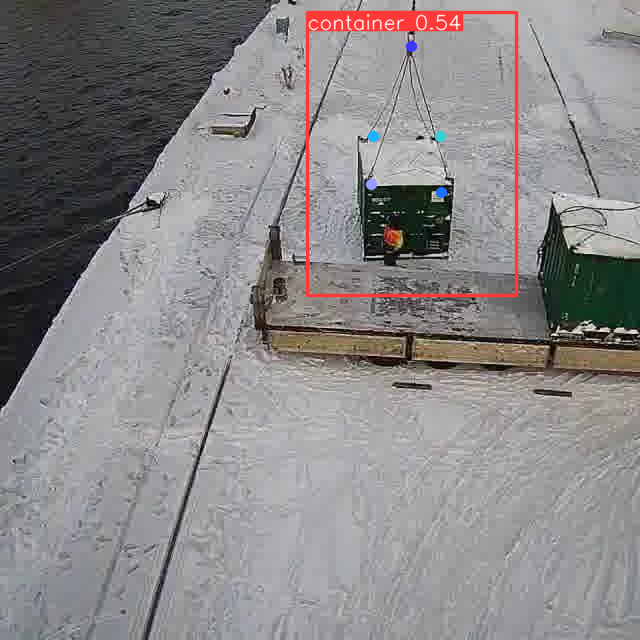

In [25]:
# Визуализируем распознанные ключевые точки на примере рандомного изображения из тестовой выборки
random_file = random.choice(os.listdir(f"data/labeled/v5/test/images"))
image_path = os.path.join("data/labeled/v5/test/images", random_file)

print(image_path)

results = model(image_path)

print(results[0].keypoints.xy)

r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

## Calculate Keypoint Angle


In [31]:
# Смотрим тензоры для изображения, на котором тестировали

# results уже содержат нужный тензор
keypoints = results[0].keypoints.xy[0]

# Переносим тензор на CPU и преобразуем его в список
keypoints_list = keypoints.cpu().numpy().tolist()

# Теперь keypoints_list содержит координаты точек в виде списка списков:
# [
#   [344.5808, 62.5307],
#   [368.8192, 194.1467],
#   ...
# ]
keypoints_list

[[411.83642578125, 46.34873962402344],
 [371.350830078125, 184.46717834472656],
 [441.42474365234375, 192.55442810058594],
 [373.7408142089844, 136.73049926757812],
 [440.96820068359375, 136.31089782714844]]

In [32]:
# Cписок координат keypoints_list

# 1. Находим вершину (самую верхнюю точку)
vertex = min(keypoints_list, key=lambda x: x[1])

# 2. Находим две основные точки, расположенные по горизонтали
# Отбрасываем вершину из поиска
base_points = [point for point in keypoints_list if point != vertex]

# Находим ближайшие по горизонтали точки к средней точке по оси X
mid_x = sum(point[0] for point in base_points) / len(base_points)
base_points = sorted(base_points, key=lambda x: abs(x[0] - mid_x))

# Берем две ближайшие к средней точке
point1, point2 = base_points[:2]

# 3. Расчет угла между прямыми
def angle_between_points(p1, p2, p3):
    # Векторы p1p2 и p1p3
    p1p2 = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    p1p3 = np.array([p3[0] - p1[0], p3[1] - p1[1]])

    # Скалярное произведение векторов
    dot_product = np.dot(p1p2, p1p3)

    # Длины векторов
    len_p1p2 = np.linalg.norm(p1p2)
    len_p1p3 = np.linalg.norm(p1p3)

    # Угол между векторами в радианах
    angle = math.acos(dot_product / (len_p1p2 * len_p1p3))

    # Угол в градусах
    angle_degrees = math.degrees(angle)

    return angle_degrees

# Рассчитываем угол
angle = angle_between_points(vertex, point1, point2)

print(f"The angle between the lines is: {angle} degrees")

The angle between the lines is: 40.79838381167992 degrees
